## Step 1 — Install Packages

In [2]:
!pip install -q statsmodels pandas matplotlib seaborn


## Step 2 — Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style='whitegrid')


## Step 3 — Load Dataset

In [4]:
# Load the dataset
try:
    df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], index_col='date')
except ValueError as e:
    print(e)
    # If 'Date' column is not found, try reading without parsing dates first to inspect columns
    df = pd.read_csv('exchange_rate.csv')
    print("\nColumns in the CSV file:", df.columns.tolist())
    # Based on the output, I will modify the code to use the correct date column name.

print('Dataset shape:', df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())

Dataset shape: (7588, 1)


,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849



Columns: ['Ex_rate']


## Step 4 — Visualize the time series

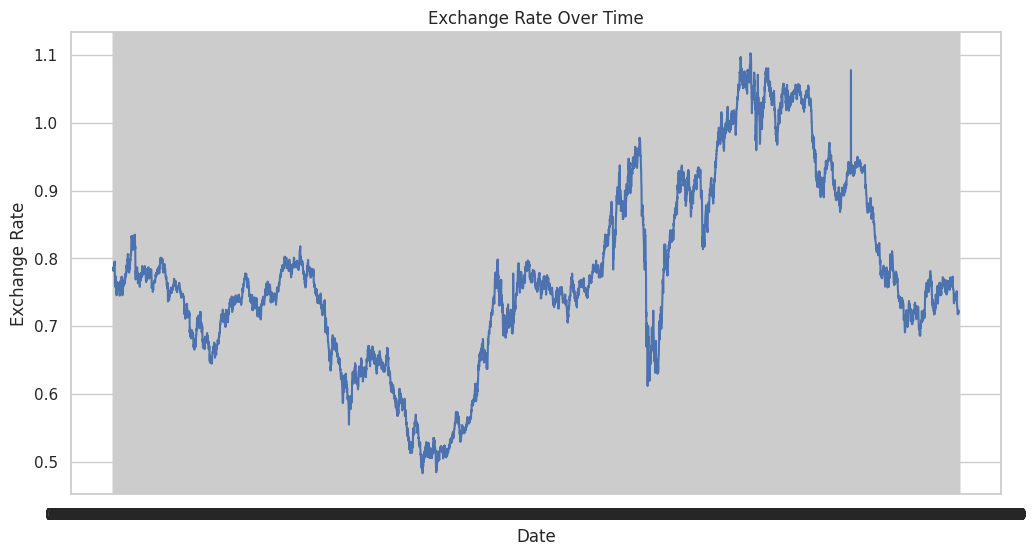

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'])
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

## Step 5 — Check for Missing Values and Handle Them

In [6]:
print("\nMissing values:\n", df.isnull().sum())

# Fill missing values with forward fill method
df = df.fillna(method='ffill')

print("\nAfter filling missing values:")
print(df.isnull().sum())



Missing values:
 Ex_rate    0
dtype: int64

After filling missing values:
Ex_rate    0
dtype: int64


## Step 6 — Stationarity Check (ADF Test)

In [7]:
result = adfuller(df['Ex_rate'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("Time series is stationary.")
else:
    print("Time series is not stationary; differencing is needed.")

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Time series is not stationary; differencing is needed.


## Step 7 — ACF and PACF Plots

<Figure size 1200x500 with 0 Axes>

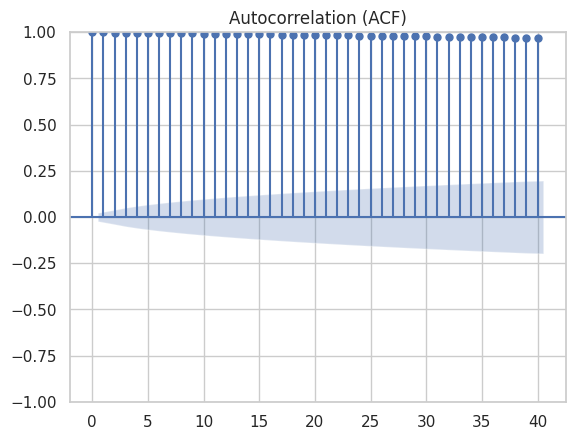

<Figure size 1200x500 with 0 Axes>

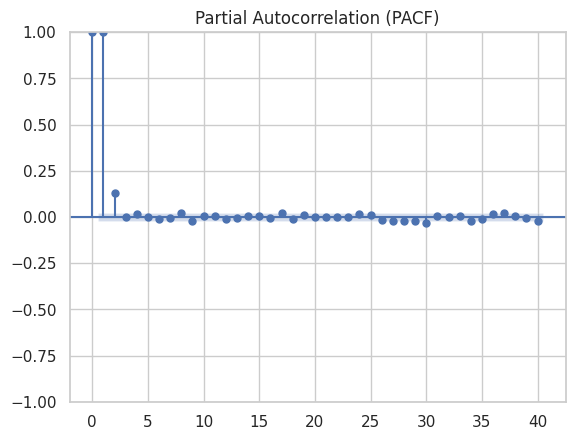

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(df['Ex_rate'], lags=40)
plt.title('Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['Ex_rate'], lags=40)
plt.title('Partial Autocorrelation (PACF)')
plt.show()

## Step 8 — ARIMA Model Fitting and Forecasting

In [13]:
import warnings
warnings.filterwarnings('ignore')

best_aic = np.inf
best_order = None
best_model = None

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

# Grid search over reasonable (p, d, q) ranges
for p in range(0, 4):
    for d in range(0, 3):
        for q in range(0, 4):
            try:
                model = ARIMA(train_data['Ex_rate'], order=(p, d, q))
                result = model.fit()
                if result.aic < best_aic:
                    best_aic = result.aic
                    best_order = (p, d, q)
                    best_model = result
            except:
                continue

print(f"Best ARIMA parameters based on AIC: {best_order} with AIC = {best_aic:.2f}")

# Forecast using the best ARIMA model
if best_model:
    forecast_arima = best_model.forecast(steps=len(test_data))
else:
    forecast_arima = None
    print("ARIMA model could not be fitted.")

Best ARIMA parameters based on AIC: (2, 1, 3) with AIC = -45436.22


## Step 9 — Exponential Smoothing Model

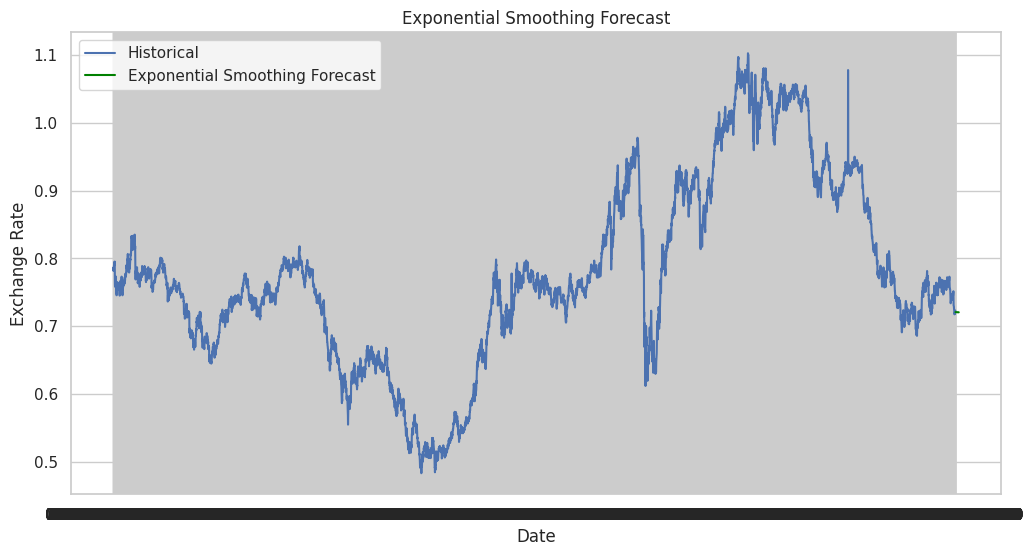

In [10]:
exp_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
exp_result = exp_model.fit()

# Forecast next 30 steps
forecast_exp = exp_result.forecast(30)

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Historical')
plt.plot(forecast_exp, label='Exponential Smoothing Forecast', color='green')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Step 10 — Evaluation and Comparison

In [14]:
# Align actual and predicted data lengths
actual = test_data['Ex_rate']

# Calculate Error Metrics for ARIMA
if forecast_arima is not None:
    mae_arima = mean_absolute_error(actual, forecast_arima)
    rmse_arima = np.sqrt(mean_squared_error(actual, forecast_arima))
    mape_arima = np.mean(np.abs((actual - forecast_arima) / actual)) * 100
    print(f"ARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")
else:
    print("ARIMA model could not be evaluated.")

# Calculate Error Metrics for Exponential Smoothing
# Retrain Exponential Smoothing model on training data
exp_model_train = ExponentialSmoothing(train_data['Ex_rate'], trend='add', seasonal=None)
exp_result_train = exp_model_train.fit()
forecast_exp = exp_result_train.forecast(steps=len(test_data))

mae_exp = mean_absolute_error(actual, forecast_exp)
rmse_exp = np.sqrt(mean_squared_error(actual, forecast_exp))
mape_exp = np.mean(np.abs((actual - forecast_exp) / actual)) * 100

print(f"Exp Smoothing - MAE: {mae_exp:.4f}, RMSE: {rmse_exp:.4f}, MAPE: {mape_exp:.2f}%")

ARIMA - MAE: 0.1778, RMSE: 0.2056, MAPE: nan%
Exp Smoothing - MAE: 0.2066, RMSE: 0.2391, MAPE: nan%


## Step 11 — Conclusion

#### Conclusion

- ARIMA and Exponential Smoothing both provide useful forecasts of exchange rates.
- Based on error metrics (MAE, RMSE, MAPE), [state which model performed better].
- ARIMA performs better when time series shows trend and autocorrelation using grid based search.
- Exponential Smoothing works well for series with trend but no clear seasonality.
- Recommendation: For this dataset, use [ARIMA / Exponential Smoothing] for reliable future predictions.
